In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import block_diag
sns.set_theme(style="darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.vae_models import CVAE
import src.experiment_lib as experiment_lib
from src.forecasting_metrics import *
from src.imputation_lib import *

In [4]:
config_dir = 'runs/impu-forecast/'
config_folder = 'sweep_Jan14_14-17-57/'
config = json.load(open(config_dir + config_folder +'config.json', 'r'))

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=1000
Mean of enrolments: 0.31
Number of Training Points...............1500580
Number of Testing Points................491760
Number of Validation Points.............491626
Number of Missing Points.................2154
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_43


In [6]:
num_users = user_ids["test"][-1]+1

In [7]:
model = CVAE(input_dim=trainset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(os.path.join(config_dir, config_folder))
model.eval()

USING SIGMA_LIM!
USING SIGMA_LIM!


CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=152, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=1000, out_features=1000, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=1000, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (mu): NNBlock(
          (input_layer): Sequential(
            (0

In [8]:
torch.cuda.empty_cache()
import gc
gc.collect()

30

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.prior_params = {key: value.to(device) for key, value in model.prior_params.items()}

In [10]:
log_space = config["data"]["scaling"]["log_space"]
zero_id = config["data"]["scaling"]["zero_id"]
shift = config["data"]["scaling"]["shift"]

In [11]:
test_conditions = torch.tensor(conditioner.transform(condition_set["val"])).float()

In [12]:
num_test_days = int(X_test.shape[0]/num_users)

In [98]:
user_idx = np.arange(1000, 1010)
day_idx = 3

x_test = np.reshape(X_test, (num_users, num_test_days, -1))[user_idx, [day_idx]]
# x_test = valset.inputs[[user_idx*num_test_days + day_idx]]

x_condition_set = {key: np.reshape(np.reshape(value, (num_users, num_test_days,-1))[user_idx,[day_idx]], (-1, value.shape[-1])) for key, value in condition_set["test"].items()}

# x_condition_set = {key: value[[user_idx*num_test_days + day_idx]] for key, value in condition_set["val"].items()}

In [99]:
x_test_missing = x_test.copy()
x_test_missing[:,24:] = np.nan

In [100]:
x_samples, z_samples, condition_samples = cvae_imputation(model.eval(), x_test_missing, conditioner=conditioner, condition_set=x_condition_set, num_samples=100, num_iter=2000, warmup_steps=10, verbose_freq=100, device=device)

Pseudo-Gibbs warm-up is starting...
Pseudo-Gibbs warm-up has ended.
Metropolis-within-Gibbs is starting...
Iteration: 0
Acceptance ratio: %20.0
Iteration: 100
Acceptance ratio: %25.6
Iteration: 200
Acceptance ratio: %23.1
Iteration: 300
Acceptance ratio: %24.9
Iteration: 400
Acceptance ratio: %30.4
Iteration: 500
Acceptance ratio: %24.8
Iteration: 600
Acceptance ratio: %28.799999999999997
Iteration: 700
Acceptance ratio: %37.6
Iteration: 800
Acceptance ratio: %37.5
Iteration: 900
Acceptance ratio: %37.1
Iteration: 1000
Acceptance ratio: %34.2
Iteration: 1100
Acceptance ratio: %34.0
Iteration: 1200
Acceptance ratio: %32.4
Iteration: 1300
Acceptance ratio: %40.1
Iteration: 1400
Acceptance ratio: %36.5
Iteration: 1500
Acceptance ratio: %37.7
Iteration: 1600
Acceptance ratio: %36.7
Iteration: 1700
Acceptance ratio: %38.0
Iteration: 1800
Acceptance ratio: %39.2
Iteration: 1900
Acceptance ratio: %34.300000000000004
Metropolis-within-Gibbs has ended.


In [101]:
model.to(device)
x_params = model.decoder(torch.concat((torch.tensor(z_samples).float().to(device), torch.tensor(condition_samples).float().to(device)), dim=-1))
for key, value in x_params.items():
    x_params[key] = value.view(-1,x_test_missing.shape[0], value.shape[-1]).detach().cpu()
model.to("cpu")
pass

In [102]:
U = model.decoder.get_SigmaMapper()

In [103]:
x_params["mu"].shape

torch.Size([100, 10, 48])

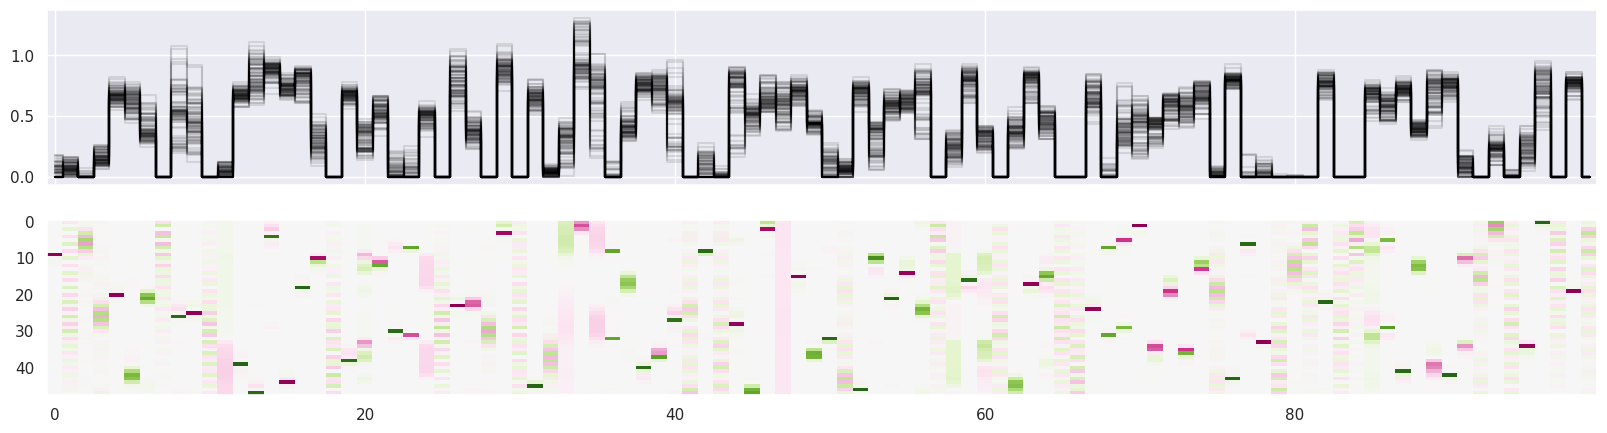

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
ax[0].step(np.arange(x_params["sigma"].shape[-1]),x_params["sigma"][:,8].T.detach().cpu().numpy(), where='mid', color='black', alpha=0.1)
ax[1].imshow(U.detach().cpu().numpy(), aspect='auto', cmap='PiYG')
plt.grid(False)

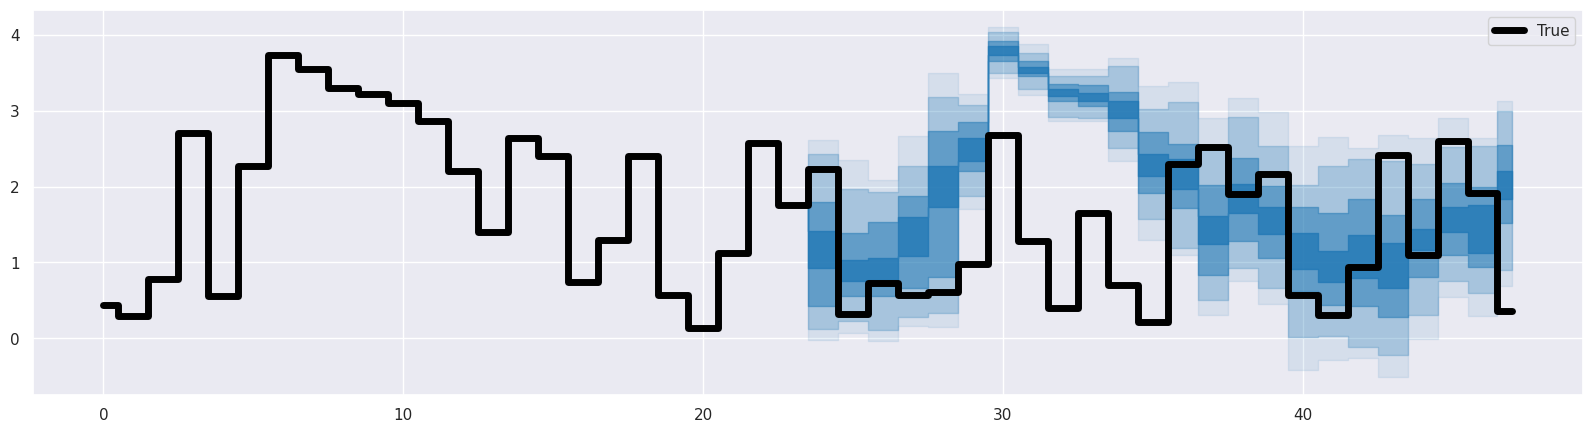

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
idx=8
# plt.plot(x_params["mu"].T.detach().cpu().numpy())
# plt.plot(x_samples[:100].T)
plt.fill_between(np.arange(x_samples.shape[-1]), np.quantile(x_samples[:,idx], 0.05, axis=0), np.quantile(x_samples[:,idx], 0.95, axis=0), color='tab:blue', alpha=0.10, step='mid')
plt.fill_between(np.arange(x_samples.shape[-1]), np.quantile(x_samples[:,idx], 0.10, axis=0), np.quantile(x_samples[:,idx], 0.90, axis=0), color='tab:blue', alpha=0.25, step='mid')
plt.fill_between(np.arange(x_samples.shape[-1]), np.quantile(x_samples[:,idx], 0.25, axis=0), np.quantile(x_samples[:,idx], 0.75, axis=0), color='tab:blue', alpha=0.5, step='mid')
plt.fill_between(np.arange(x_samples.shape[-1]), np.quantile(x_samples[:,idx], 0.40, axis=0), np.quantile(x_samples[:,idx], 0.60, axis=0), color='tab:blue', alpha=0.75, step='mid')
# plt.plot(np.quantile(x_samples, 0.5, axis=0), color='tab:blue', lw=5, alpha=1)
# plt.plot(x_test.T, color='black', lw=5)
# plt.step(np.arange(x_test.shape[-1]), x_samples[0,idx].T, color='tab:orange', lw=5, where='mid', label='Sample')
plt.step(np.arange(x_test.shape[-1]), x_test[idx].T, color='black', lw=5, where='mid', label='True')
plt.legend()
# plt.yscale('exp')
plt.show()